In [3]:
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np


In [4]:
tickers = ["ANTM.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = today

panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)


ValueError: Index contains duplicate entries, cannot reshape

In [50]:

close = panel_data["Close"]

all_weekdays = pd.date_range(start = start_date,    end= end_date, freq='B')

close = close.reindex(all_weekdays)

close = close.dropna()

#print(all_weekdays)

In [51]:
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3011 entries, 2010-01-04 to 2022-02-17
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ANTM.JK  3011 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(close)
df

array([[0.56663685],
       [0.56663685],
       [0.56663685],
       ...,
       [0.54874268],
       [0.54874268],
       [0.57113331]])

Menyiapkan Sequence data

In [54]:
close

Symbols,ANTM.JK
2010-01-04,1931.946777
2010-01-05,1931.946777
2010-01-06,1931.946777
2010-01-07,1973.945557
2010-01-08,1973.945557
...,...
2022-02-11,1845.000000
2022-02-14,1890.000000
2022-02-15,1880.000000
2022-02-16,1880.000000


In [55]:
clist = list(close['ANTM.JK'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(clist)
idx_start = idx_end - total_period

X_new = []
y_new = []

while idx_start > 0:
    x_line = clist[idx_start:idx_start+n_past]
    y_line = clist[idx_start+n_past:idx_start+total_period]

    X_new.append(x_line)
    y_new.append(y_line)

    idx_start = idx_start -1
X_new = np.array(X_new)
y_new = np.array(y_new)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

In [112]:
batch_size = 42

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

In [142]:
y_train.shape[1]

72

LSTM

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

simple_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
    Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss= 'mean_absolute_error',
    metrics = ['mean_absolute_error']
)

smod_history = simple_model.fit(X_train_rs, y_train, validation_split=0.2, epochs = 5, batch_size = batch_size, shuffle = True)



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 216, 64)           16896     
                                                                 
 lstm_33 (LSTM)              (None, 216, 64)           33024     
                                                                 
 lstm_34 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 72)                4680      
                                                                 
Total params: 87,624
Trainable params: 87,624
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
35/35 [==============================] - 24s 516ms/step - loss: 1074.9218 - mean_absolute_error: 1074.9218 - val_loss: 1067.2623 - val_mean_absolute_error: 1067.2623
Epoch

In [143]:
preds = simple_model.predict(X_test_rs)
preds_train = simple_model.predict(X_train_rs)

In [152]:
# invert predictions
trainPredict = scaler.inverse_transform(preds_train)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(preds)
testY = scaler.inverse_transform(y_test)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [146]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from math import sqrt
print("Nilai R2: "+str(r2_score(y_test,preds)))
print("Nilai MAE: "+str(mean_absolute_error(y_test, preds)))
print("Nilai RMSE: "+str(sqrt(mean_absolute_error(y_test, preds))))

Nilai R2: -3.6558849885944493
Nilai MAE: 1054.6054790646167
Nilai RMSE: 32.474689822454295


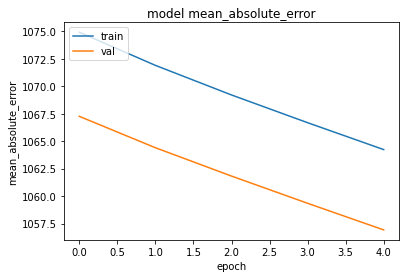

In [131]:
plt.plot(smod_history.history['mean_absolute_error'])
plt.plot(smod_history.history['val_mean_absolute_error']) 
plt.title('model mean_absolute_error')
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

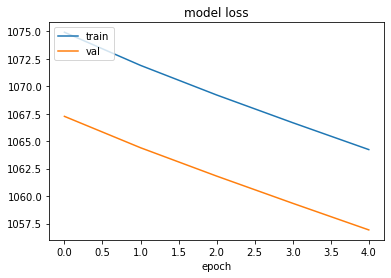

In [132]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [148]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_timesteps:len(trainPredict)+n_timesteps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(n_timesteps*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (1824,72) into shape (1824,1)